In [6]:
from google.colab import files
 
uploaded = files.upload()

In [790]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

In [791]:
df = pd.read_csv('Emissions_Country_india.csv', index_col="Year")
df = df.loc[df['Item'] == 'Rice Cultivation']
df = df[['Value']]
df.columns = ['Emission']

In [792]:
temp = pd.read_csv('Annual_Surface_Temperature_Change.csv')

temp = temp.loc[temp['Country'] == 'India']
temp = temp.drop(['ObjectId', 'Country', 'ISO2', 'ISO3', 'Indicator', 'Code', 'Unit', 'Source'], axis=1).reset_index(drop=True)
temp['x'] = 'temperature'
temp = temp.set_index('x').T
temp = temp.reset_index(drop=True)
temp_list = temp["temperature"].to_list()
df["Temperature"] = temp_list[:-2]

Text(0.5, 1.0, 'Correlation Heatmap')

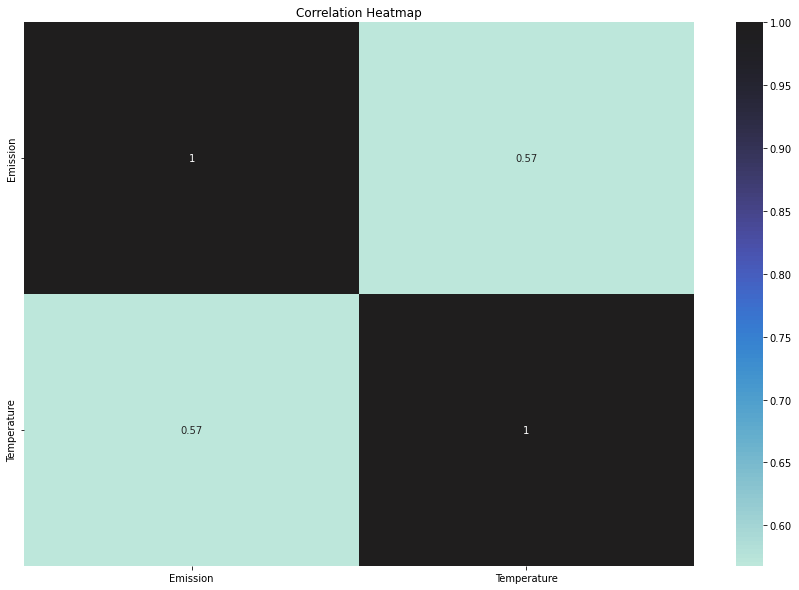

In [793]:
fig = plt.figure(figsize=(15,10))
sns.heatmap(df[['Emission', 'Temperature']].corr(method='pearson'), center=1, annot = True)
plt.title("Correlation Heatmap")

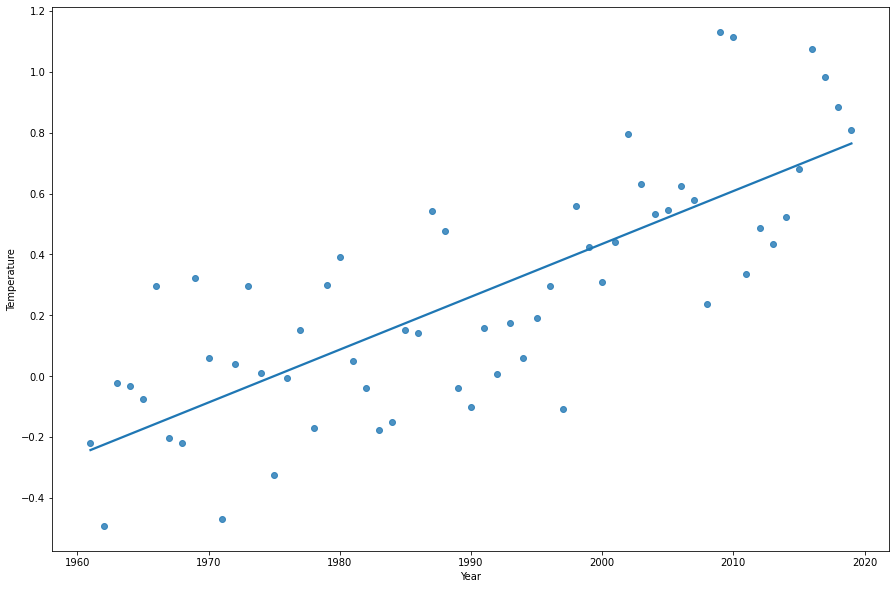

In [794]:
fig = plt.figure(figsize=(15,10))

sns.regplot(x = df.index,
            y = "Temperature", 
            ci = None,
            data = df)

[Text(0, 0.5, 'Δ in Temperature change'),
 Text(0.5, 0, 'Year'),
 Text(0.5, 1.0, 'Temperature Change Trend')]

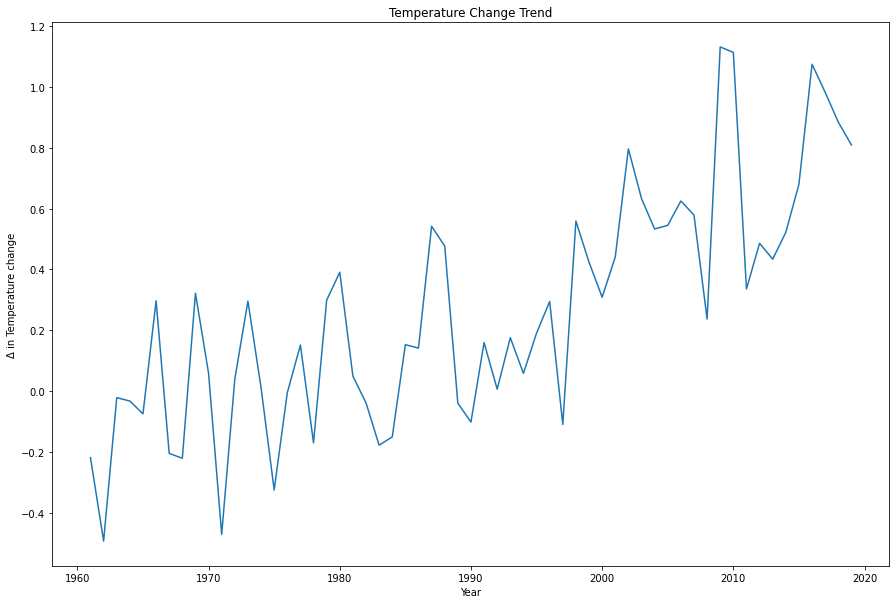

In [795]:
fig = plt.figure(figsize=(15,10))

sns.lineplot(data=df, 
             x=df.index, 
             y="Temperature").set(title='Temperature Change Trend', 
                                  xlabel='Year', 
                                  ylabel='\u0394 in Temperature change')


# AutoReg

In [796]:
temp_series = df[['Temperature']]
temp_series = temp_series.append(pd.DataFrame(temp_list[-2:], index=[2020,2021], columns =['Temperature']))

In [797]:
train=temp_series[:len(temp_series)-13]
test=temp_series[len(temp_series)-13:]

In [798]:
print(f'P-value: {adfuller(temp_series)[1]}')

P-value: 0.958528930370966


In [799]:
model = AutoReg(train, lags=11).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


In [800]:
print(model.summary())

                            AutoReg Model Results                             
Dep. Variable:            Temperature   No. Observations:                   48
Model:                    AutoReg(11)   Log Likelihood                  10.229
Method:               Conditional MLE   S.D. of innovations              0.184
Date:                Sun, 25 Sep 2022   AIC                             -2.688
Time:                        01:16:52   BIC                             -2.122
Sample:                            11   HQIC                            -2.489
                                   48                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept           0.0721      0.040      1.789      0.074      -0.007       0.151
Temperature.L1      0.4023      0.156      2.587      0.010       0.098       0.707
Temperature.L2     -0.0192      

In [801]:
pred=model.predict(start=len(train), end=len(temp_series)-1, dynamic=False)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [802]:
pred = pred.to_frame().set_index(test.index)
pred.columns = ["Temperature"]

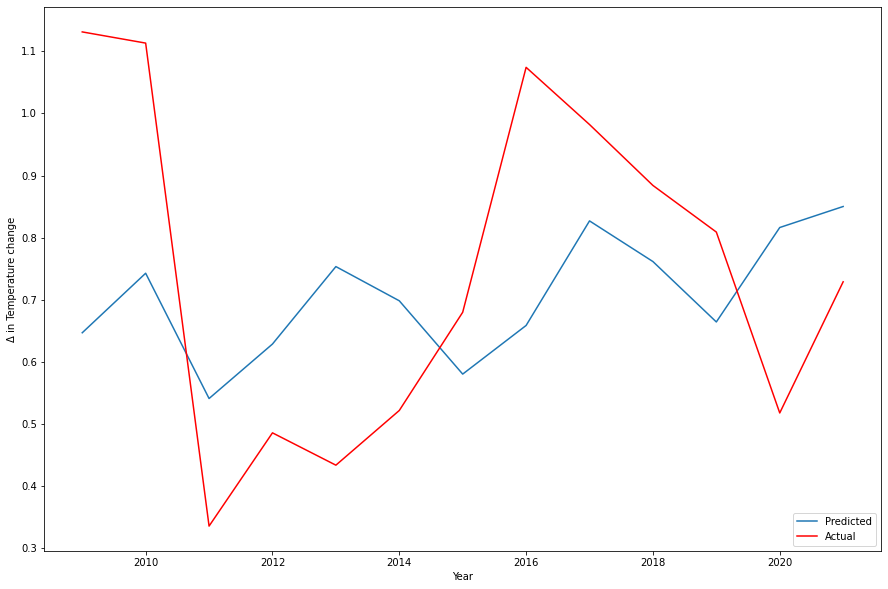

In [803]:
fig = plt.figure(figsize=(15,10))

plt.plot(pred)
plt.plot(test, color='red')
plt.ylabel("\u0394 in Temperature change")
plt.xlabel("Year")
plt.legend(["Predicted", "Actual"], loc ="lower right")

In [804]:
pred_future = model.predict(start=len(temp_series)-1, end=len(temp_series)+8, dynamic=False)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [805]:
pred_index = []
for i in range(10):
  x = temp_series.index[len(temp_series)-1] + i+1
  pred_index.append(x)
pred_future = pred_future.to_frame()
pred_future["Year"] = pred_index
pred_future.columns = ['Temperature', 'Year']
pred_future = pred_future[['Temperature']].set_index(pred_future.Year)
temp_series = temp_series.append(pred_future)

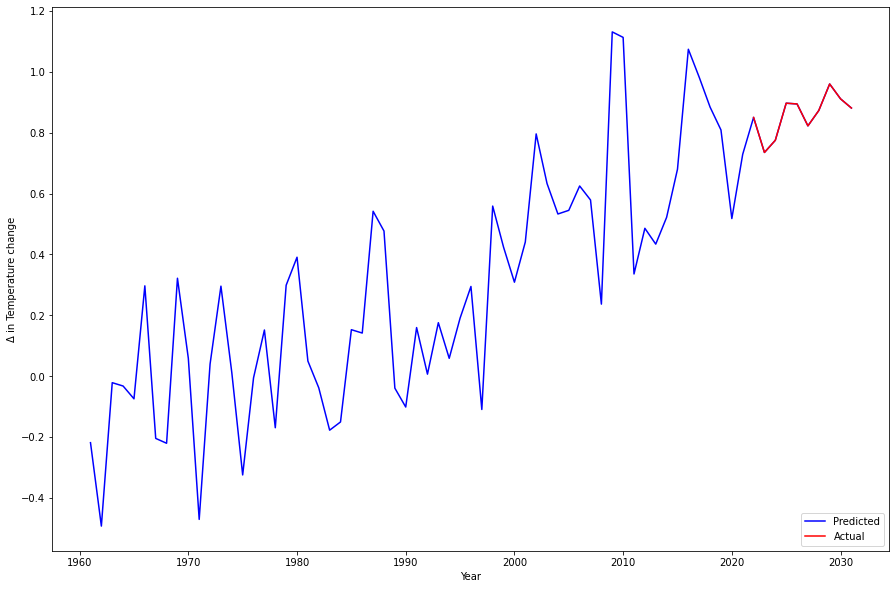

In [806]:
fig = plt.figure(figsize=(15,10))

plt.plot(temp_series, color='blue')
plt.plot(pred_future, color='red')

plt.ylabel("\u0394 in Temperature change")
plt.xlabel("Year")
plt.legend(["Predicted", "Actual"], loc ="lower right")